In [3]:
import scamp

In [4]:
s = scamp.Session()
clarinet = s.new_part('clarinet')

Using preset Clarinet for clarinet


In [5]:
a = b = 1
for _ in range(10):
    clarinet.play_note(64+a, 0.7, 0.25)
    a, b = b, (a+b) % 6

In [9]:
import os
import json
import numpy as np
import random
import glob
import music21 as m21
import djalgo as dj
import tensorflow as tf
import gpflow

def scan_midi_files(directory, max_files=None):
    """
    Scans the specified directory for MIDI files using glob with a while loop.

    Args:
        directory (str): The directory to scan for MIDI files.
        max_files (int, optional): The maximum number of files to scan. If None, all files are scanned.

    Returns:
        list: The list of MIDI files found.
    """
    search_pattern = os.path.join(directory, '**', '*.mid*')
    midi_files = []

    # Utiliser glob.iglob pour obtenir un itérateur
    for file in glob.iglob(search_pattern, recursive=True):
        midi_files.append(file)
        if max_files is not None and len(midi_files) >= max_files:
            break

    return midi_files

2024-05-02 11:06:21.588468: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 11:06:21.592514: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-02 11:06:21.635266: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 11:06:22.738453: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [10]:
midi_files = scan_midi_files('_midi')

In [11]:
import mido
from mido import MidiFile, MidiTrack

def repair_midi(input_path, output_path, split_channels=False, change_instruments=None):
    """
    Repairs a MIDI file by splitting or merging tracks and optionally changing instruments.
    
    Args:
        input_path (str): Path to the input MIDI file.
        output_path (str): Path to save the repaired MIDI file.
        split_channels (bool): If True, splits tracks into separate tracks based on channel.
        change_instruments (dict): Optional dictionary mapping from channel to new instrument program number.
    """
    mid = MidiFile(input_path)
    new_mid = MidiFile()
    
    if split_channels:
        # Create a track for each channel (0-15)
        tracks_per_channel = [MidiTrack() for _ in range(16)]
        
        # Distribute messages to appropriate track based on channel
        for track in mid.tracks:
            for msg in track:
                if not msg.is_meta and hasattr(msg, 'channel'):
                    if change_instruments and msg.type == 'program_change' and msg.channel in change_instruments:
                        msg.program = change_instruments[msg.channel]
                    tracks_per_channel[msg.channel].append(msg)
                else:
                    # Append meta messages to all tracks
                    [t.append(msg) for t in tracks_per_channel]
                    
        # Add non-empty tracks to the new MIDI file
        for track in tracks_per_channel:
            if any(not msg.is_meta for msg in track):  # Ensuring the track is not empty
                new_mid.tracks.append(track)
    else:
        # Merge all tracks into one or keep as is, based on the MIDI file's structure
        combined_track = MidiTrack()
        for track in mid.tracks:
            for msg in track:
                if change_instruments and msg.type == 'program_change' and msg.channel in change_instruments:
                    msg.program = change_instruments[msg.channel]
                combined_track.append(msg)
        new_mid.tracks.append(combined_track)
        
    # Save the repaired MIDI file
    new_mid.save(output_path)

# Example usage:

for file in midi_files:
    repair_midi(file, file.replace('_midi/', '_midi-repaired/'), split_channels=True)


In [12]:
midi_files = scan_midi_files('_midi-repaired')

In [13]:
import numpy as np
import music21 as m21

def replace_none_with_weighted_value(data):
    # Copy data to avoid modifying the original array directly
    modified_data = np.array(data, dtype=object)
    for i in range(len(modified_data)):
        if modified_data[i] is None:
            nearest_prev = nearest_next = None
            dist_prev = dist_next = float('inf')
            
            for j in range(i - 1, -1, -1):
                if modified_data[j] is not None:
                    nearest_prev = modified_data[j]
                    dist_prev = i - j
                    break
            
            for k in range(i + 1, len(modified_data)):
                if modified_data[k] is not None:
                    nearest_next = modified_data[k]
                    dist_next = k - i
                    break
            
            if nearest_prev is not None and nearest_next is not None:
                total_weight = 1 / dist_prev + 1 / dist_next
                weighted_value = (nearest_prev * (1 / dist_prev) + nearest_next * (1 / dist_next)) / total_weight
            elif nearest_prev is not None:
                weighted_value = nearest_prev
            elif nearest_next is not None:
                weighted_value = nearest_next
            else:
                weighted_value = 0  # Default or handle as needed

            modified_data[i] = weighted_value
    return modified_data


def prepare_data_for_gpflow(midi_files, num_instruments=2):
    features = []  # Will hold the input features
    targets = []   # Will hold the targets with instrument index

    for midi_file in midi_files:
        score = m21.converter.parse(midi_file)
        parts = score.getElementsByClass(m21.stream.Part)
        for idx, part in enumerate(parts[:num_instruments]):
            key = part.analyze('key')
            scale_list = dj.harmony.Scale(key.tonic.name, key.mode).generate()            
            for element in part.flatten().notesAndRests:
                offset = float(element.offset)
                duration = float(element.duration.quarterLength)
                activity = 0 if isinstance(element, m21.note.Rest) else 1
                
                if isinstance(element, m21.note.Note):
                    pitch = element.pitch.midi
                elif isinstance(element, m21.chord.Chord):
                    pitch = element.pitches[0].midi
                else:
                    pitch = None
                
                degree = dj.utils.get_degree_from_pitch(pitch, scale_list=scale_list, tonic_pitch=key.tonic.midi) if pitch is not None else None
                if num_instruments < 2:
                    features.append([offset])  # Features (time offset)
                else:
                    features.append([offset, idx])  # Features (time offset)
               
                # Concatenating instrument index with each target
                targets.append([degree, duration, activity])

    # Replace None values in degrees with a weighted average of the nearest non-None values
    all_degrees = [t[0] for t in targets]
    all_degrees_noNone = replace_none_with_weighted_value(all_degrees)
    targets = [[all_degrees_noNone[i], t[1], t[2]] for i, t in enumerate(targets)]
        
    X = np.array(features).astype(np.float64)
    Y = np.array(targets).astype(np.float64)

    return X, Y

def scaling(x):
    mean = np.mean(x, axis=0)
    std = np.std(x, axis=0)
    return (x - mean) / std, mean, std

def minmax_scaling(data, min_range=-1, max_range=1):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    scaled_data = (data - min_vals) / (max_vals - min_vals) * (max_range - min_range) + min_range
    return scaled_data, min_vals, max_vals

In [56]:
midi_files = scan_midi_files('_midi-repaired')
midi_files = [midi_files[4]]
print(midi_files)
num_instruments=2
X, Y = prepare_data_for_gpflow(midi_files, num_instruments=num_instruments)

['_midi-repaired/tetris.mid']


In [57]:
Y_sc = Y.copy()
Y_sc[:, :2], min_Y, max_y = minmax_scaling(Y[:, :2])

X_sc = X.copy()
X_sc[:, 0], min_X, max_X = minmax_scaling(X[:, 0])

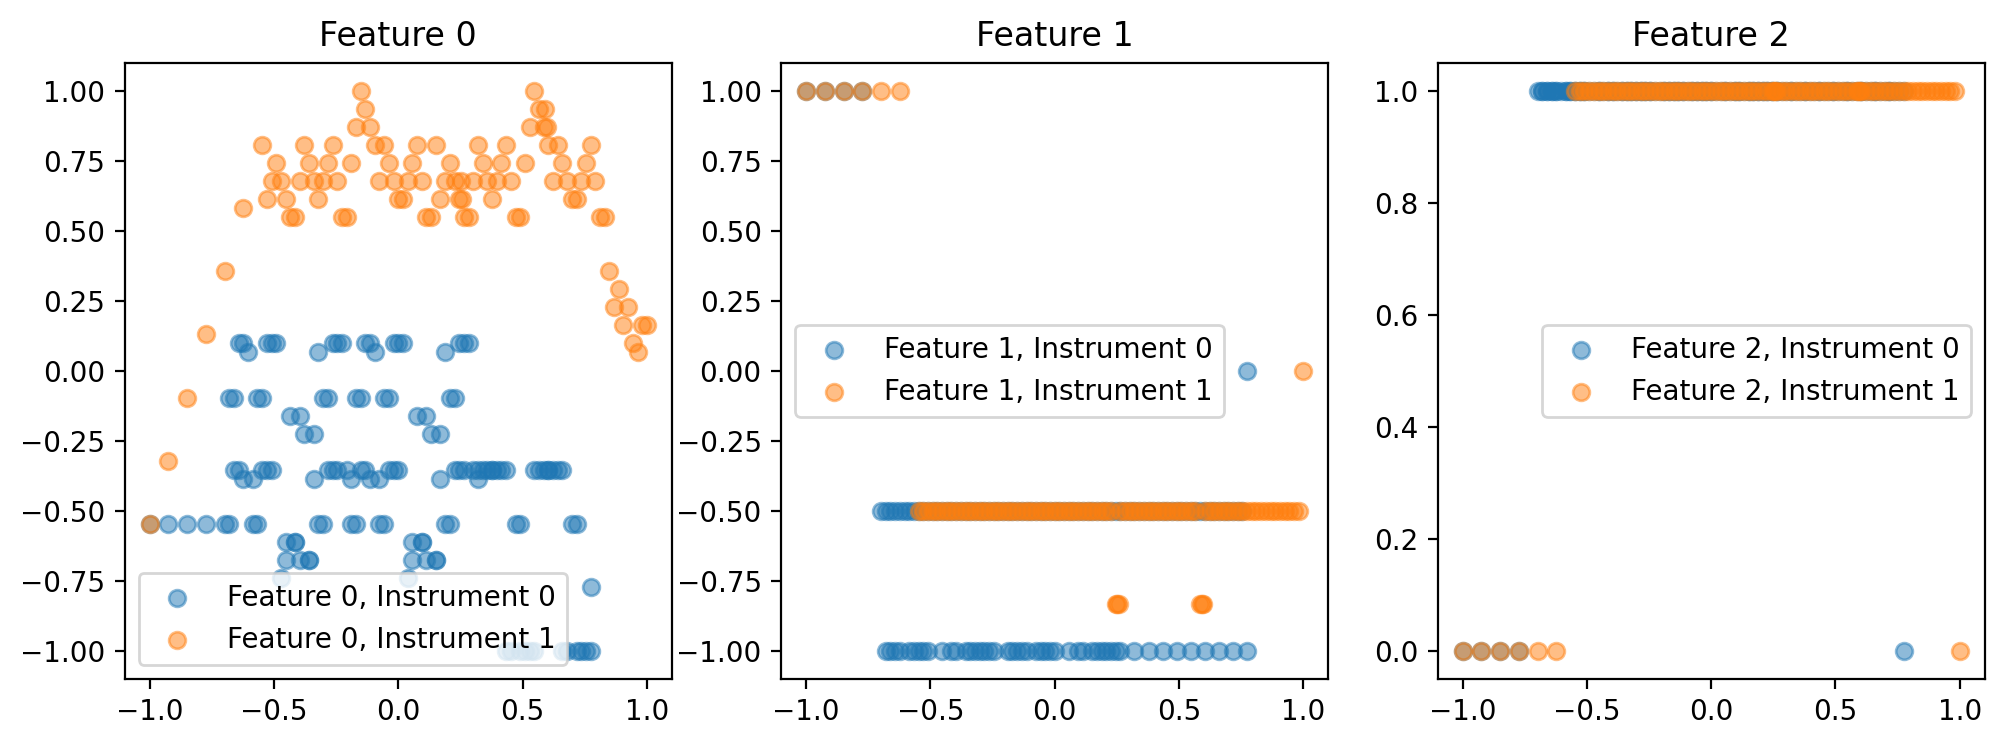

In [58]:
import matplotlib.pyplot as plt
if num_instruments < 2:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(3):
        ax[i].scatter(X_sc[:, 0], Y_sc[:, i], label=f'Feature {i}', alpha=0.5)
        ax[i].set_title(f'Feature {i}')
        ax[i].legend()
else:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        for j in range(2):
            filter_instr = X[:, 1] == j
            ax[i].scatter(X_sc[filter_instr, 0], Y_sc[filter_instr, i], label=f'Feature {i}, Instrument {j}', alpha=0.5)
        ax[i].set_title(f'Feature {i}')
        ax[i].legend()


In [59]:
gpflow.config.set_default_jitter(1e-6)

matern_kernel = gpflow.kernels.Matern32(lengthscales=1.0, variance=10.0)  # Increased variance
periodic_kernel_short = gpflow.kernels.Periodic(
    base_kernel=gpflow.kernels.Matern32(lengthscales=1.0, variance=1.0),  # Increase base kernel variance
    period=0.001
)
periodic_kernel_long = gpflow.kernels.Periodic(
    base_kernel=gpflow.kernels.Matern32(lengthscales=1.0, variance=1.0),  # Increase base kernel variance
    period=0.5
)

# Combine kernels
complex_kernel = gpflow.kernels.Sum([matern_kernel, periodic_kernel_short, periodic_kernel_long])


if num_instruments < 2:
    num_outputs = 1  # Single output for a single instrument
    kernel_degrees = complex_kernel
    kernel_durations = complex_kernel
else:
    num_outputs = int(np.max(X_sc[:, 1]) + 1)  # Assuming column 1 is the index of instruments
    # Coregionalization kernel setup
    coreg_kernel = gpflow.kernels.Coregion(output_dim=num_outputs, rank=num_outputs, active_dims=[1])
    coreg_kernel.W.assign(np.random.rand(num_outputs, num_outputs))
    kernel_degrees = complex_kernel * coreg_kernel
    kernel_durations = complex_kernel * coreg_kernel
    kernel_activities = complex_kernel * coreg_kernel

# Setup the GP models for each output
# Use X_sc which contains the scaled features including time and instrument index
model_degrees = gpflow.models.VGP(data=(X_sc, Y[:, 0:1]), kernel=kernel_degrees, likelihood=gpflow.likelihoods.Gaussian())
model_durations = gpflow.models.VGP(data=(X_sc, Y[:, 1:2]), kernel=kernel_durations, likelihood=gpflow.likelihoods.Gaussian())
if num_instruments >= 2:
    model_activities = gpflow.models.VGP(data=(X_sc, Y[:, 2:3]), kernel=kernel_activities, likelihood=gpflow.likelihoods.Bernoulli())

# Define training data for each model using the appropriate columns from Y
training_data_degrees = (X_sc, Y_sc[:, 0:1])  # First column of Y for degrees
training_data_durations = (X_sc, Y_sc[:, 1:2])  # Second column of Y for durations
if num_instruments >= 2:
    training_data_activities = (X_sc, Y_sc[:, 2:3])  # Third column of Y for activities

# Optimization using GPflow's built-in optimizer for each model
optimizer = gpflow.optimizers.Scipy()
print('Fitting degrees model...')
optimizer.minimize(model_degrees.training_loss_closure(),
                   variables=model_degrees.trainable_variables,
                   options=dict(maxiter=1000))
print('Fitting durations model...')
optimizer.minimize(model_durations.training_loss_closure(),
                   variables=model_durations.trainable_variables,
                   options=dict(maxiter=1000))
if num_instruments >= 2:
    print('Fitting activities model...')
    optimizer.minimize(model_activities.training_loss_closure(),
                    variables=model_activities.trainable_variables,
                    options=dict(maxiter=1000))



Fitting degrees model...


2024-05-02 11:14:49.329811: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:49.348457: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:49.368820: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:49.391460: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:49.413135: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular out

Fitting durations model...


2024-05-02 11:14:51.408610: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:51.442271: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:51.459431: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:51.476941: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


Fitting activities model...


2024-05-02 11:14:53.462665: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:53.482666: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.
2024-05-02 11:14:53.499449: W tensorflow/core/kernels/linalg/cholesky_op.cc:56] Cholesky decomposition was not successful. Eigen::LLT failed with error code 1. Filling lower-triangular output with NaNs.


In [60]:
n_values = 100
values = np.linspace(-1, 1, n_values)
if num_instruments < 2:
    X_new = values[:, None]
else:
    X_new_instruments = []
    for i in range(num_instruments):
        X_new_instruments.append(np.column_stack((values, np.ones(n_values) * i)))
    X_new = np.vstack(X_new_instruments)

In [61]:
X_new

array([[-1.        ,  0.        ],
       [-0.97979798,  0.        ],
       [-0.95959596,  0.        ],
       [-0.93939394,  0.        ],
       [-0.91919192,  0.        ],
       [-0.8989899 ,  0.        ],
       [-0.87878788,  0.        ],
       [-0.85858586,  0.        ],
       [-0.83838384,  0.        ],
       [-0.81818182,  0.        ],
       [-0.7979798 ,  0.        ],
       [-0.77777778,  0.        ],
       [-0.75757576,  0.        ],
       [-0.73737374,  0.        ],
       [-0.71717172,  0.        ],
       [-0.6969697 ,  0.        ],
       [-0.67676768,  0.        ],
       [-0.65656566,  0.        ],
       [-0.63636364,  0.        ],
       [-0.61616162,  0.        ],
       [-0.5959596 ,  0.        ],
       [-0.57575758,  0.        ],
       [-0.55555556,  0.        ],
       [-0.53535354,  0.        ],
       [-0.51515152,  0.        ],
       [-0.49494949,  0.        ],
       [-0.47474747,  0.        ],
       [-0.45454545,  0.        ],
       [-0.43434343,

In [65]:
predictions = []
degrees_sc, _ = model_degrees.predict_y(X_new)
durations_sc, _ = model_durations.predict_y(X_new)
predictions.append(degrees_sc)
predictions.append(durations_sc)
if num_instruments >= 2:
    activities = tf.sigmoid(model_activities.predict_f_samples(X_new, 1))
    instrument_01 = tf.round(activities)
    predictions.append(instrument_01)

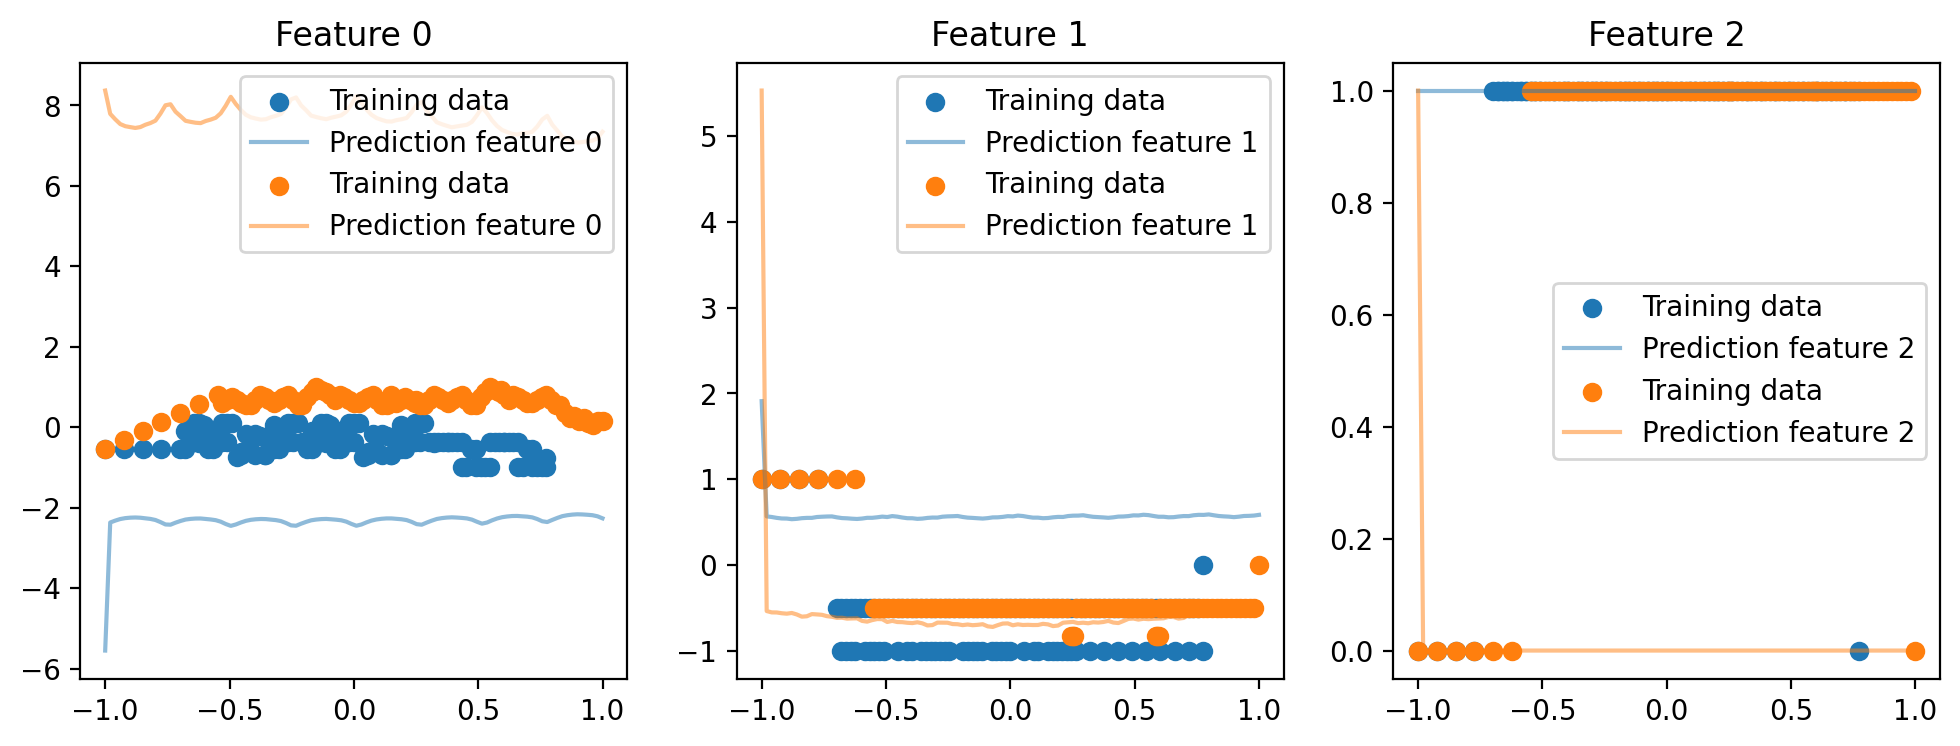

In [73]:
import matplotlib.pyplot as plt
if num_instruments < 2:
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(3):
        ax[i].scatter(X_sc[:, 0], Y_sc[:, i], label='Training data')
        ax[i].plot(X_new[:, 0], predictions[i].numpy().flatten(), label=f'Prediction feature {i}', alpha=0.5)
        ax[i].set_title(f'Feature {i}')
        ax[i].legend()
else:
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(3):
        for j in range(num_instruments):
            filter_instr_tr = X_sc[:, 1] == j
            filter_instr_pr = X_new[:, 1] == j
            ax[i].scatter(X_sc[filter_instr_tr, 0], Y_sc[filter_instr_tr, i], label='Training data')
            ax[i].plot(X_new[filter_instr_pr, 0], predictions[i].numpy().flatten()[filter_instr_pr], label=f'Prediction feature {i}', alpha=0.5)
        ax[i].set_title(f'Feature {i}')
        ax[i].legend()


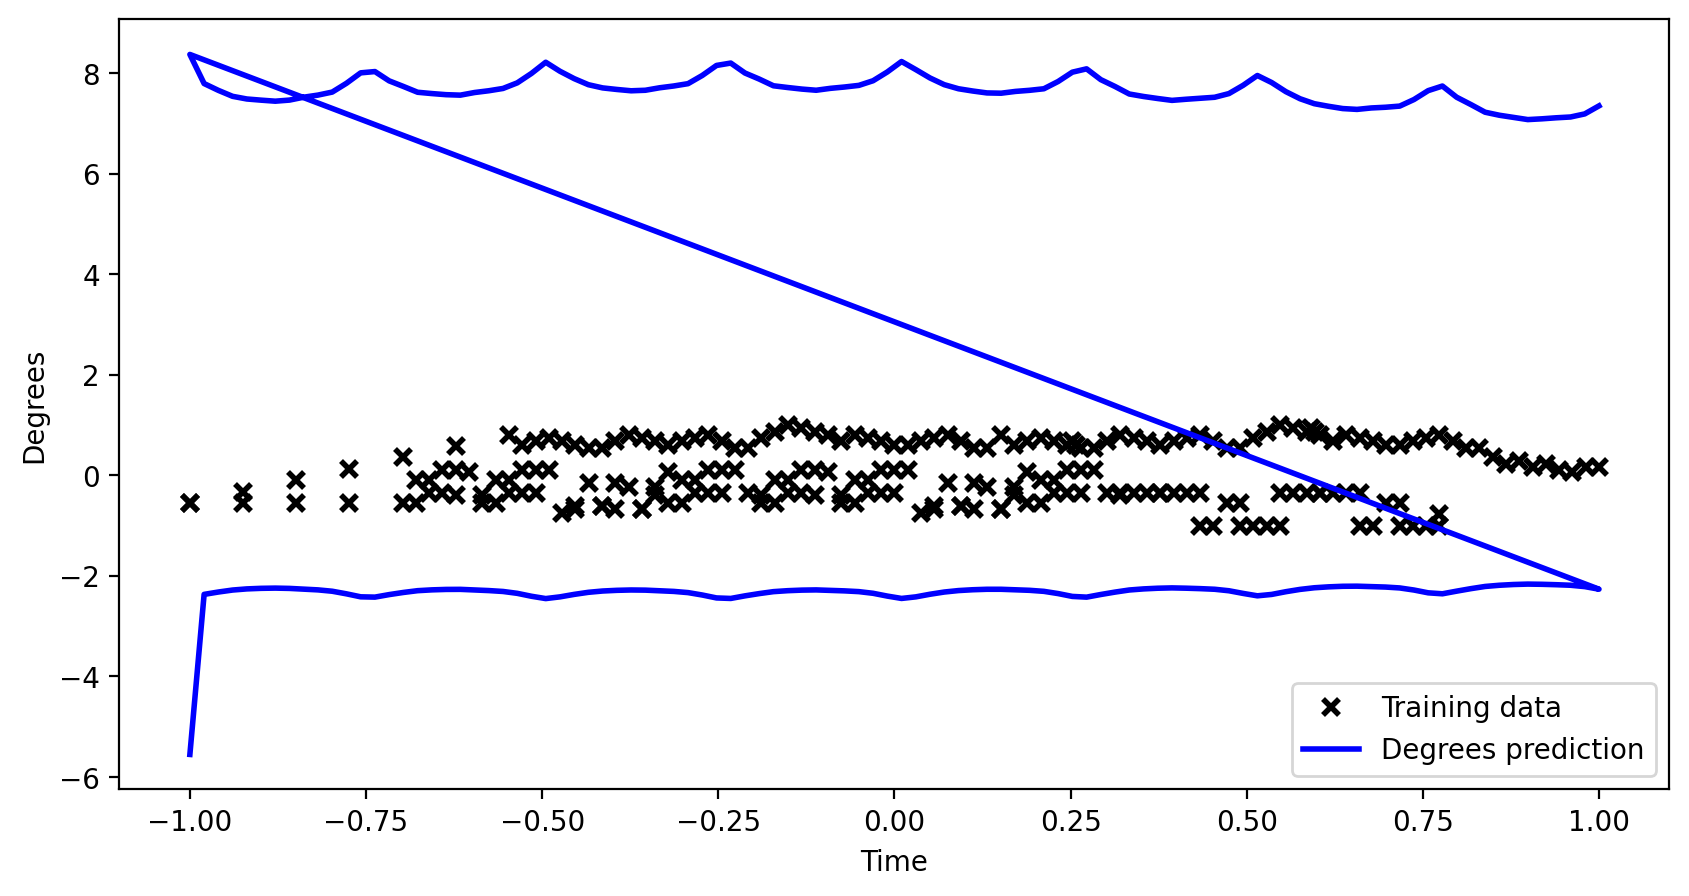

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(X_sc[:, 0], Y_sc[:, 0], 'kx', mew=2, label='Training data')
plt.plot(X_new[:, 0], degrees_sc.numpy().flatten(), 'b', lw=2, label='Degrees prediction')
plt.xlabel('Time')
plt.ylabel('Degrees')
plt.legend()

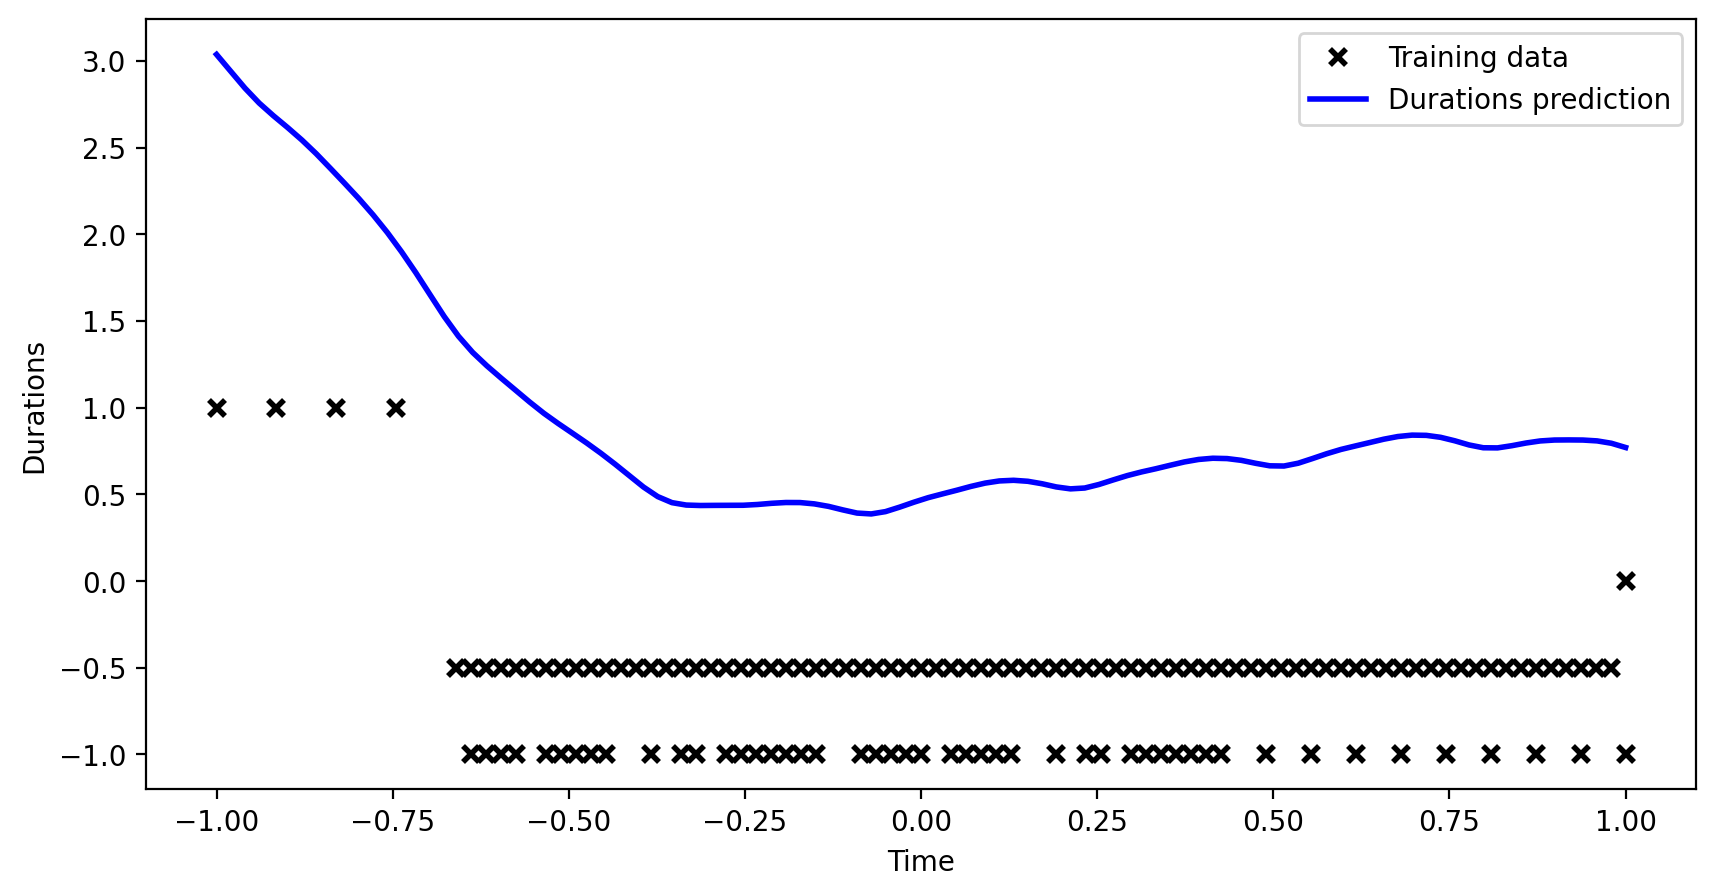

In [55]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(X_sc[:, 0], Y_sc[:, 1], 'kx', mew=2, label='Training data')
plt.plot(X_new[:, 0], durations_sc.numpy().flatten(), 'b', lw=2, label='Durations prediction')
plt.xlabel('Time')
plt.ylabel('Durations')
plt.legend()